# Platform Positioning

In [12]:
from __future__ import print_function

In [13]:
import random as random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.metrics import euclidean_distances

###  Generate Well Concept Data

In [14]:
from dummydatacreator import  GenerateWellConcept # This is not supported in Azure notebooks

In [15]:
num_of_concepts = 30

region_x_min = -60.62
region_x_max = -59.98
region_y_min = 9.87
region_y_max = 10.45
WellConcepts = [GenerateWellConcept(region_x_min, region_x_max, region_y_min, region_y_max) for i in range(num_of_concepts)]

In [16]:
WC_name, WC_points, WC_resource = list(zip(*WellConcepts))

In [17]:
print(WellConcepts[0])

['W-21', [-60.55019571355951, 10.040057708338125], 133.15926734094336]


### Well Concept / Platform Intersection

In [20]:
def ArePointsCloseTogether(pointA, pointB, distance):
    return (euclidean_distances([pointA], [pointB]) <= distance)[0][0]

print(ArePointsCloseTogether([10,2], [0,0], 10))

False


In [19]:
def AreWCsCloseToPlatforom(WellConceptsXY, PlatformXY, distance):    
    return [ArePointsCloseTogether(wcXY, PlatformXY, distance) for wcXY in WellConceptsXY]

## Plotting

In [21]:
def plot_WC_Platform(WC_XY,WC_name, WC_res: np.array, plat_x, plat_y, plat_name, innerradius, outerradius, figsize):

    '''
    Plots Well Concepts and Platforms in Euclidean geometry
    '''
    
    
    #Unpack XY coordinates
    WC_x = [XY[0]for XY in WC_points] 
    WC_y = [XY[1]for XY in WC_points]
    

    fig, ax = plt.subplots(figsize=figsize)

    
    platform_radius = plt.Circle((plat_x, plat_y), radius = outerradius,fill=True,color='#FF8000', zorder=0 )
    ax.add_artist(platform_radius)
    
    platform_radius = plt.Circle((plat_x, plat_y), radius = innerradius,fill=True,color='#00CC00', zorder=1 )
    ax.add_artist(platform_radius)
    
    ax.scatter(plat_x, plat_y, marker = 'x', s=1000, zorder=2 )
   

    
    scatter = ax.scatter(WC_x, WC_y, c = WC_res, cmap="winter", s=100, label=WC_res, zorder=2)
    
    fig.colorbar(scatter, ax=ax)

    
    for i, x in enumerate(WC_x):
        ax.annotate(WC_name[i], ([WC_x[i], WC_y[i]]), zorder=2)

    ax.annotate(plat_name, (plat_x, plat_y))
    plt.show()

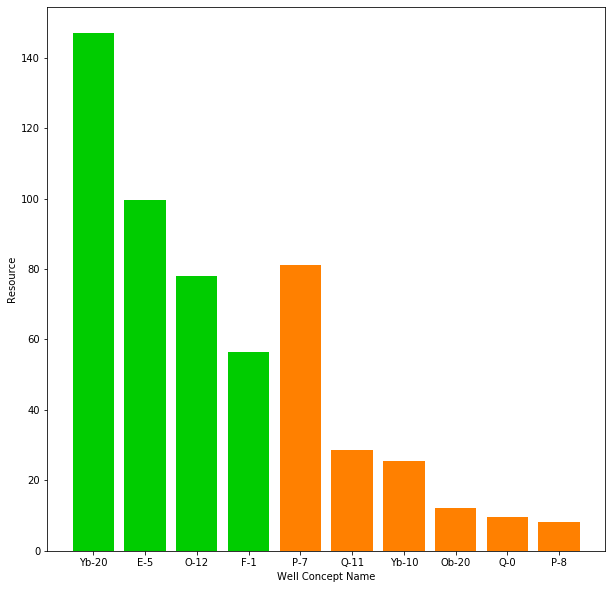

In [22]:
def CreamMe(plat_x, plat_y, innerradius, outerradius, figsize):
    WC_within_inner = AreWCsCloseToPlatforom(WC_points,[plat_x, plat_y], innerradius)
    WC_within_outer = AreWCsCloseToPlatforom(WC_points,[plat_x, plat_y], outerradius)
    WC_between = [~WC_within_inner[i] * WC_within_outer[i] for i in range(len(WC_within_outer))]
    
    col_inner = ["#00CC00"]
    
    
    fig, ax = plt.subplots(figsize=figsize)    

    dfinner = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource})[WC_within_inner].sort_values(by="Resource",ascending=False)
    dfbetween = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource})[WC_between].sort_values(by="Resource",ascending=False)
    
    ax.bar(dfinner['Well Concept'], dfinner['Resource'], color='#00CC00')
    ax.bar(dfbetween['Well Concept'], dfbetween['Resource'], color='#FF8000')

    ax.set_xlabel("Well Concept Name")
    ax.set_ylabel("Resource")

    plt.show()

CreamMe(-60.16, 10.07, 0.1,0.2,(10,10))

In [ ]:
def CreamMe(plat_x, plat_y, innerradius, outerradius, figsize):
    WC_within_inner = AreWCsCloseToPlatforom(WC_points,[plat_x, plat_y], innerradius)
    WC_within_outer = AreWCsCloseToPlatforom(WC_points,[plat_x, plat_y], outerradius)
    WC_between = [~WC_within_inner[i] * WC_within_outer[i] for i in range(len(WC_within_outer))]
    
    col_inner = ["#00CC00" for ]
    
    
    fig, ax = plt.subplots(figsize=figsize)    

    dfinner = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource})[WC_within_inner].sort_values(by="Resource",ascending=False)
    dfbetween = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource})[WC_between].sort_values(by="Resource",ascending=False)
    
    ax.bar(dfinner['Well Concept'], dfinner['Resource'], color='#00CC00')
    ax.bar(dfbetween['Well Concept'], dfbetween['Resource'], color='#FF8000')

    ax.set_xlabel("Well Concept Name")
    ax.set_ylabel("Resource")

    plt.show()

CreamMe(-60.16, 10.07, 0.1,0.2,(10,10))

In [84]:
userInputs = [widgets.BoundedFloatText(
    value=round(region_x_min +(random.random()*(region_x_max-region_x_min)), 2 ),
    min=region_x_min,
    max=region_x_max,
    step=0.01,
    description='X:',
    disabled=False
),
widgets.BoundedFloatText(
    value=round(region_y_min +(random.random()*(region_y_max-region_y_min)), 2 ),
    min=region_y_min,
    max=region_y_max,
    step=0.01,
    description='Y:',
    disabled=False
),
  widgets.BoundedFloatText(
    value=0.05,
    min=0.01,
    max=100,
    step=0.01,
    description='Radius:',
    disabled=False
)]



In [85]:
#%matplotlib inline 
from IPython.display import display

output = widgets.Output(layout={'border': '1px solid black'})


def on_button_clicked(event):
    output.clear_output()

    with output:
        plat_x = userInputs[0].value
        plat_y = userInputs[1].value
        radius = userInputs[2].value
        plot_WC_Platform(WC_points, WC_name, WC_resource,plat_x,plat_y,"platform", radius,radius*1.3, (12,10))
        CreamMe(plat_x, plat_y, radius,radius*1.3, (5,5))
    
        print("Button clicked.")        
        
button = widgets.Button(
    description='click me',
    layout={'width': '300px'},
    button_style='success', 
    tooltip='Run',
    icon='refresh'
)

display(widgets.Box(userInputs), button)


button.on_click(on_button_clicked)


Box(children=(BoundedFloatText(value=-60.06, description='X:', max=-59.98, min=-60.62, step=0.01), BoundedFloa…

Button(button_style='success', description='click me', icon='refresh', layout=Layout(width='300px'), style=But…

In [86]:
output

Output(layout=Layout(border='1px solid black'))